In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
df=pd.read_csv('AmesHousing.csv')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
df.isnull().sum()


Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64

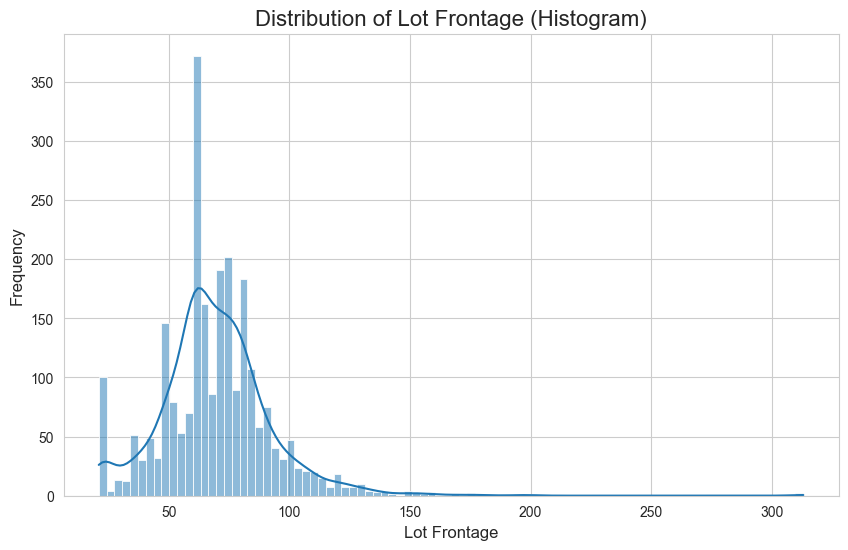

In [4]:
#Dropping rows with null values in 'LotFrontage' for plotting
df_clean = df.dropna(subset=['Lot Frontage'], inplace=False)
#inplace set to false so, this dropped column is temporary only.
sns.set_style('whitegrid')

#Plotting Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='Lot Frontage', kde=True)
plt.title('Distribution of Lot Frontage (Histogram)', fontsize=16)
plt.xlabel('Lot Frontage', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('lot_frontage_histogram.png')
plt.show()

**We wll use the median to fill because data is not balanced. The histogram shows that most of the houses have a similar lot frontage, but a few have an extremely large lot frontage. These are called outliers.**


In [5]:
lot_median=df['Lot Frontage'].median()
df['Lot Frontage']=df['Lot Frontage'].fillna(lot_median)

In [6]:
df.shape


(2930, 82)

In [7]:
df.drop_duplicates()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,68.0,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


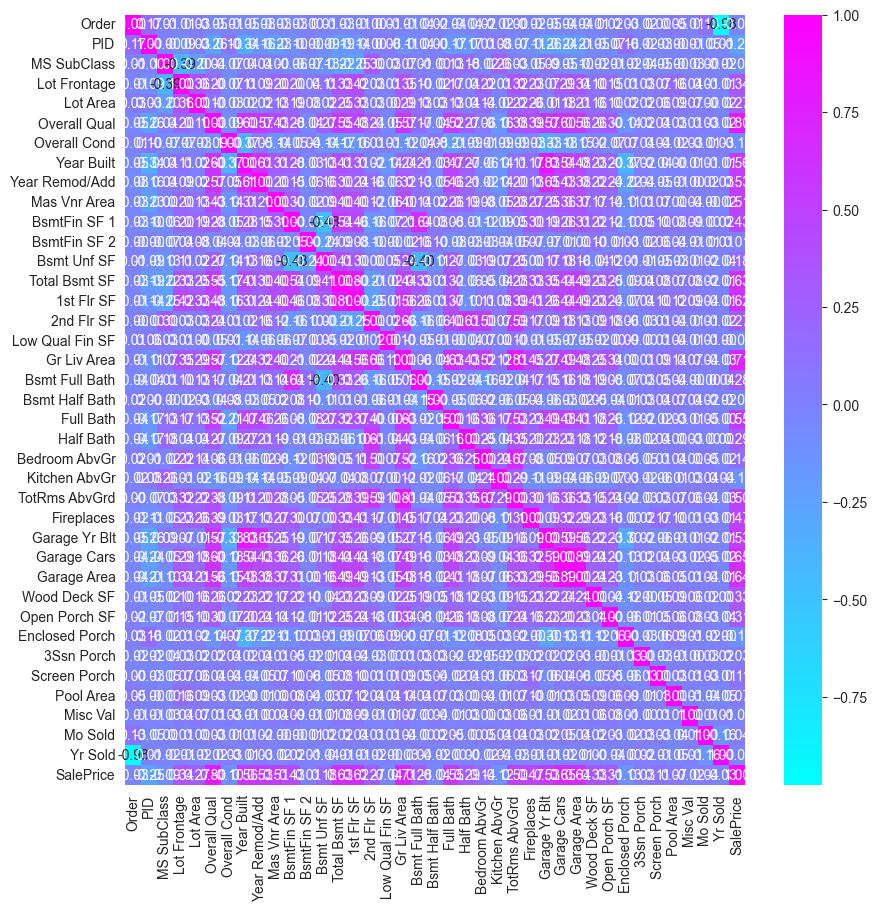

In [8]:
#we will operate on 'df'. we already filled NULL values.
correlation=df.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='cool', fmt=".2f")
plt.savefig('HeatMap.png')

## Findings from the Heatmap

#### 10 Most Related Column Pairs

These pairs have correlation coefficients with the highest absolute values (closest to 1 or -1).

* OverallQual and SalePrice (0.81)
* GrLivArea and SalePrice (0.71)
* GarageCars and GarageArea (0.88)
* YearBuilt and OverallQual (0.57)
* TotRmsAbvGrd and GrLivArea (0.83)
* GarageArea and SalePrice (0.62)
* FullBath and GrLivArea (0.63)
* MasVnrArea and YearRemod/Add (0.49)
* OverallQual and TotalBsmtSF (0.54)
* YearBuilt and SalePrice (0.52)

#### 10 Most Correlated Columns with SalePrice

These columns have the strongest positive or negative relationships with SalePrice. The higher the absolute value of the correlation coefficient, the stronger the relationship.

* OverallQual (0.81)
* GrLivArea (0.71)
* GarageCars (0.64)
* GarageArea (0.62)
* TotalBsmtSF (0.61)
* 1stFlrSF (0.61)
* FullBath (0.56)
* TotRmsAbvGrd (0.53)
* YearBuilt (0.52)
* YearRemod/Add (0.51)

In [9]:
def remove_outliers(df, column_name, factor=1.5):

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    #filter out rows outside the bounds
    mask = (df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)

    return df[mask]

<Axes: ylabel='Gr Liv Area'>

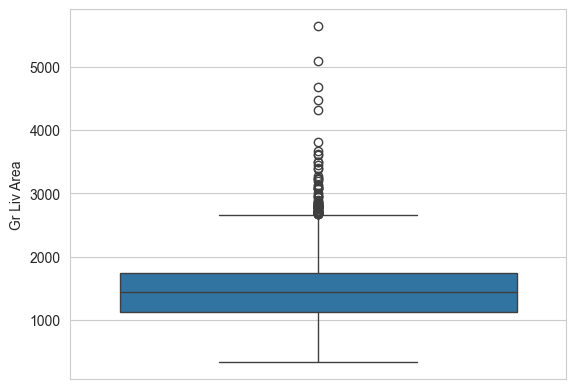

In [10]:
sns.boxplot(data=df, y='Gr Liv Area')

In [11]:
#Removing Outliers
df_cleaned = remove_outliers(df, 'Gr Liv Area')

Similarly, removing outliers for other columns too!!

<Axes: ylabel='1st Flr SF'>

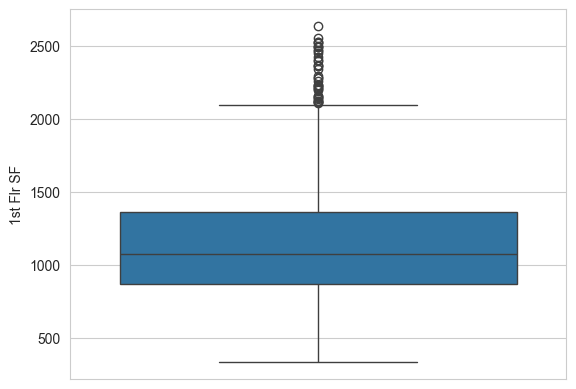

In [12]:
sns.boxplot(data=df_cleaned, y='1st Flr SF')


In [13]:
df_cleaned = remove_outliers(df, 'Garage Area')

In [14]:
df_cleaned = remove_outliers(df, 'Total Bsmt SF')

In [15]:
df_cleaned = remove_outliers(df, '1st Flr SF')

### The graph tells you that most items in this dataset are of average quality (rated 5, 6, or 7), and very poor or excellent quality items are rare.

<Axes: xlabel='count', ylabel='Overall Qual'>

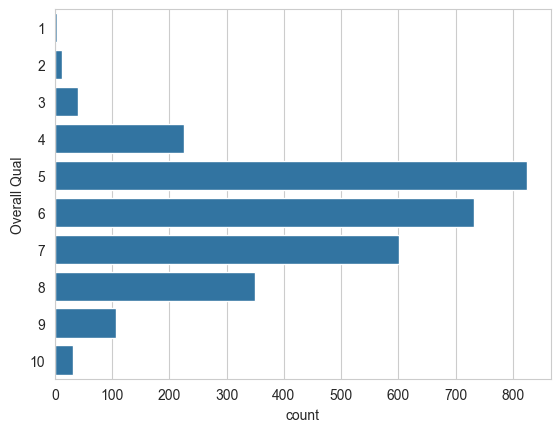

In [16]:
sns.countplot(data=df, y='Overall Qual')

### Combining Columns

In [17]:
df['TotalBath'] = df['Full Bath'] + df['Bsmt Full Bath'] + \
                  (0.5 * df['Half Bath']) + (0.5 * df['Bsmt Half Bath'])

df['TotalSF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']

porch_cols = ['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Wood Deck SF']
df['TotalPorchSF'] = df[porch_cols].sum(axis=1)

df['HouseAge'] = df['Yr Sold'] - df['Year Built']
df['YearsSinceRemod'] = df['Yr Sold'] - df['Year Remod/Add']

# half-bath (typically a room with only a toilet and a sink) is not as valuable or functional as a full-bath (which also includes a bathtub or a shower)
#used actually in real estate, like real one

In [18]:
columns_to_drop = [
    'Full Bath', 'Bsmt Full Bath', 'Half Bath', 'Bsmt Half Bath',
    'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
    'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Wood Deck SF',
    'Year Built', 'Year Remod/Add', 'Yr Sold'
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [19]:
df.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Area,Pool Area,Misc Val,Mo Sold,SalePrice,TotalBath,TotalSF,TotalPorchSF,HouseAge,YearsSinceRemod
count,2930.00000,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,...,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2929.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.019795,10147.921843,6.094881,5.563140,101.896801,442.629566,49.722431,...,472.819734,2.243345,50.635154,6.216041,180796.060068,2.217896,2546.832707,182.891468,36.434130,23.523891
std,845.96247,1.887308e+08,42.638025,21.326422,7880.017759,1.411026,1.111537,179.112611,455.590839,169.168476,...,215.046549,35.597181,566.344288,2.714492,79886.692357,0.807059,803.909695,159.834420,30.291357,20.858846
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,12789.000000,1.000000,334.000000,0.000000,-1.000000,-2.000000
25%,733.25000,5.284770e+08,20.000000,60.000000,7440.250000,5.000000,5.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,4.000000,129500.000000,1.500000,2000.000000,48.000000,7.000000,4.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,0.000000,370.000000,0.000000,...,480.000000,0.000000,0.000000,6.000000,160000.000000,2.000000,2452.000000,165.000000,34.000000,15.000000
75%,2197.75000,9.071811e+08,70.000000,78.000000,11555.250000,7.000000,6.000000,164.000000,734.000000,0.000000,...,576.000000,0.000000,0.000000,8.000000,213500.000000,2.500000,2990.000000,266.000000,54.000000,42.750000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,800.000000,17000.000000,12.000000,755000.000000,7.000000,11752.000000,1424.000000,136.000000,60.000000


In [20]:
#getting info about data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2930 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

#### NON NUMERICAL DATA-->> COLUMNS (True, False)

In [21]:
#take all the colomns having objects as data types
categorical_colomns=df.select_dtypes('object').columns.tolist()
print(categorical_colomns)

['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition']


In [22]:
# non numerical data to column conversion
from sklearn.preprocessing import OneHotEncoder

In [23]:
df_encoded = pd.get_dummies(df, columns=[ 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape',
    'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
    'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
    'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air',
    'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type',
    'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC',
    'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition'])

In [24]:
df.shape, df_encoded.shape


((2930, 72), (2930, 311))

In [25]:
df_encoded.head()

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,526301100,141.0,31770,6,5,112.0,639.0,0.0,441.0,...,False,False,False,True,False,False,False,False,True,False
1,2,526350040,80.0,11622,5,6,0.0,468.0,144.0,270.0,...,False,False,False,True,False,False,False,False,True,False
2,3,526351010,81.0,14267,6,6,108.0,923.0,0.0,406.0,...,False,False,False,True,False,False,False,False,True,False
3,4,526353030,93.0,11160,7,5,0.0,1065.0,0.0,1045.0,...,False,False,False,True,False,False,False,False,True,False
4,5,527105010,74.0,13830,5,5,0.0,791.0,0.0,137.0,...,False,False,False,True,False,False,False,False,True,False


#### Machine Learning Part

In [26]:
X = df_encoded.drop('SalePrice', axis=1) # All columns except 'SalePrice'
y = df_encoded['SalePrice'] # The 'SalePrice' column

In [27]:
X


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,526301100,141.0,31770,6,5,112.0,639.0,0.0,441.0,...,False,False,False,True,False,False,False,False,True,False
1,2,526350040,80.0,11622,5,6,0.0,468.0,144.0,270.0,...,False,False,False,True,False,False,False,False,True,False
2,3,526351010,81.0,14267,6,6,108.0,923.0,0.0,406.0,...,False,False,False,True,False,False,False,False,True,False
3,4,526353030,93.0,11160,7,5,0.0,1065.0,0.0,1045.0,...,False,False,False,True,False,False,False,False,True,False
4,5,527105010,74.0,13830,5,5,0.0,791.0,0.0,137.0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,37.0,7937,6,6,0.0,819.0,0.0,184.0,...,False,False,False,True,False,False,False,False,True,False
2926,2927,923276100,68.0,8885,5,5,0.0,301.0,324.0,239.0,...,False,False,False,True,False,False,False,False,True,False
2927,2928,923400125,62.0,10441,5,5,0.0,337.0,0.0,575.0,...,False,False,False,True,False,False,False,False,True,False
2928,2929,924100070,77.0,10010,5,5,0.0,1071.0,123.0,195.0,...,False,False,False,True,False,False,False,False,True,False


### Dividing Training And Testing Sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 2344 samples
Testing set size: 586 samples


###  Training the Model

In [29]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Creating an XGBoost Regressor model instance
model = xgb.XGBRegressor()

In [30]:
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
predictions = model.predict(X_test)


In [32]:
from sklearn.metrics import r2_score, mean_squared_error

# R-squared score
r2 = r2_score(y_test, predictions)
print(f"R-squared (R2): {r2}")

# Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error is often more interpretable
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R2): 0.926865816116333
Mean Squared Error (MSE): 586356736.0
Root Mean Squared Error (RMSE): 24214.80406693393


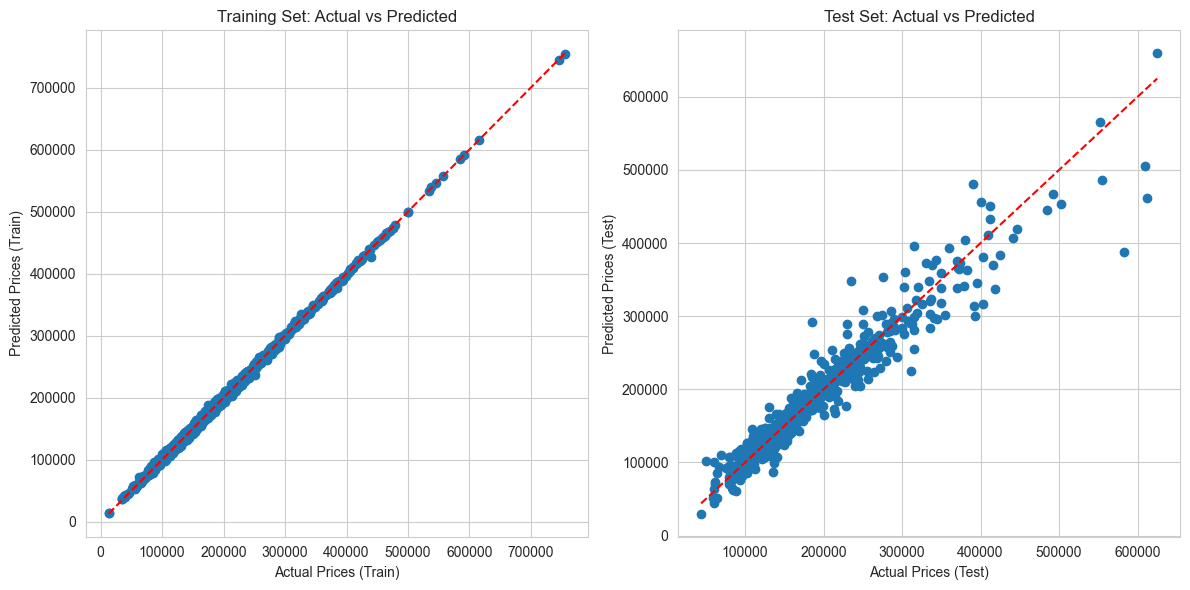

In [37]:
#generating predictions on the training data for comparison
train_predictions = model.predict(X_train)

#Training Data: Actual vs Predicted
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
plt.scatter(y_train, train_predictions)
plt.xlabel("Actual Prices (Train)")
plt.ylabel("Predicted Prices (Train)")
plt.title("Training Set: Actual vs Predicted")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--') # 45-degree line
plt.savefig('training_predictions.png') # Save the first figure



#Test Data: Actual vs Predicted

plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
plt.scatter(y_test, predictions)
plt.xlabel("Actual Prices (Test)")
plt.ylabel("Predicted Prices (Test)")
plt.title("Test Set: Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # 45-degree line


plt.tight_layout() # Adjusts plot to prevent overlap
plt.show()

#### **Feature Importance**

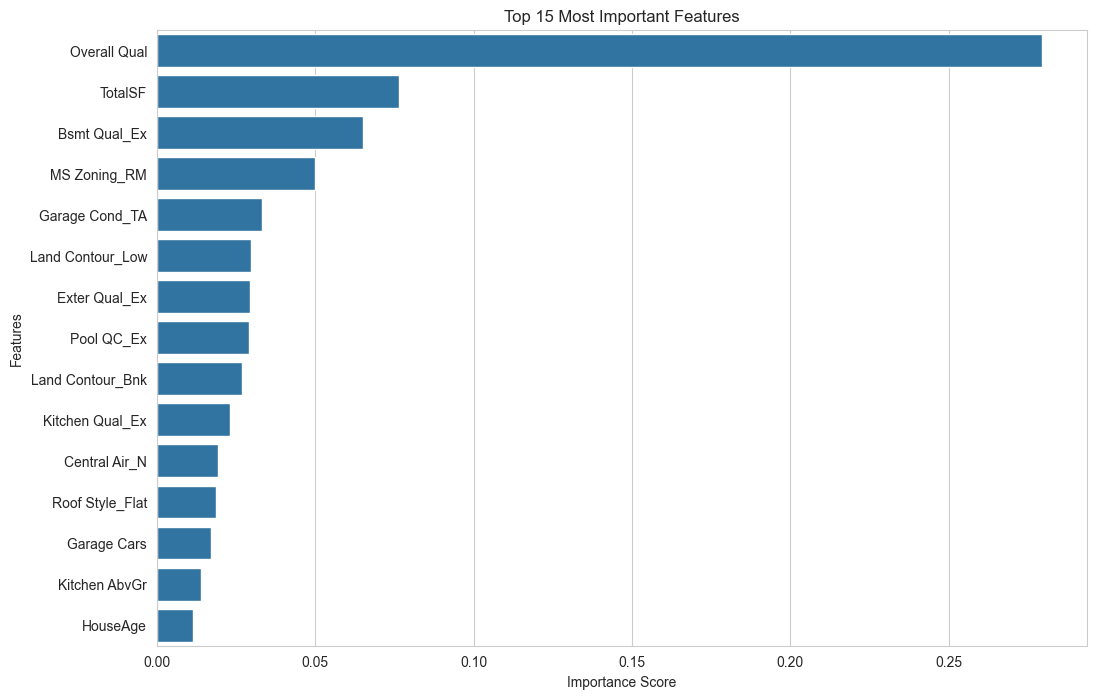

<Figure size 640x480 with 0 Axes>

In [34]:
# Creating feature names and their importance scores
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort the series in descending order and select the top 15
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
plt.savefig('top_15_features_plot.png')


In [38]:
error_df = X_test.copy()
error_df['Actual_Price'] = y_test
error_df['Predicted_Price'] = predictions

# Calculate the absolute difference between actual and predicted prices
error_df['Absolute_Error'] = abs(error_df['Actual_Price'] - error_df['Predicted_Price'])

worst_predictions = error_df.sort_values(by='Absolute_Error', ascending=False)

# Display the top 10 worst predictions
print("Top 10 Worst Predictions:")
display(worst_predictions.head(10))

Top 10 Worst Predictions:


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Actual_Price,Predicted_Price,Absolute_Error
433,434,528110090,107.0,13891,9,5,424.0,0.0,0.0,1734.0,...,False,False,False,False,False,False,True,582933,387857.56250,195075.43750
44,45,528150070,100.0,12919,9,5,760.0,2188.0,0.0,142.0,...,False,False,False,False,False,False,True,611657,461011.56250,150645.43750
2246,2247,911370460,44.0,4750,8,5,481.0,1573.0,0.0,0.0,...,True,False,False,False,True,False,False,235000,347734.00000,112734.00000
2181,2182,908154205,130.0,40094,10,5,762.0,2260.0,0.0,878.0,...,False,False,False,False,False,False,True,184750,292152.00000,107402.00000
432,433,528110020,105.0,13693,10,5,472.0,2288.0,0.0,342.0,...,True,False,False,False,False,True,False,610000,505799.56250,104200.43750
1559,1560,911370410,64.0,5587,8,5,186.0,1480.0,0.0,120.0,...,False,False,False,False,False,False,True,392500,300899.28125,91600.71875
1058,1059,528118030,108.0,13418,9,5,270.0,1420.0,0.0,430.0,...,True,True,False,False,False,False,False,390000,480644.25000,90644.25000
1538,1539,909425010,68.0,15660,7,9,312.0,341.0,0.0,457.0,...,True,False,False,False,False,True,False,311500,224833.65625,86666.34375
495,496,528321010,174.0,15138,8,5,506.0,689.0,0.0,773.0,...,True,False,False,False,False,True,False,403000,317185.84375,85814.15625
1780,1781,528431040,98.0,12291,10,5,754.0,1572.0,0.0,394.0,...,False,False,False,False,False,False,True,419005,337147.68750,81857.31250
